In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch

from rbm.definitions import DATASET_DIR, MODEL_DIR
from rbm.tmc_utils import loadTMCsave, plot_valsing_evol, loadTMCRBM2D
from rbm.functions import ComputeProbabilityTMC2D

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float

# The name of the file to analyze. It can either be the AllParameters (indexed on the number of update) or the RBM one.
# The file should be located in MODEL_DIR 
model_name = 'AllParametersDemo2d3cB.h5'


# Load dataset and model

In [2]:
data = torch.tensor(np.genfromtxt(DATASET_DIR.joinpath('data_2d_3c_balanced_seed12.d')).T, dtype=dtype, device=device)
# The data is binary with values in {-1, 1}, so we scale it to be in {0, 1}
data = (data+1)/2

_, _, V = torch.svd(data.T)
proj_data = torch.mm(data.T, V).cpu()/data.shape[0]**.5

/home/nbereux/rbm/rbm/tmc_utils.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  _, tmpS, tmpV = torch.svd(torch.tensor(f["W" + str(t)], device=device))


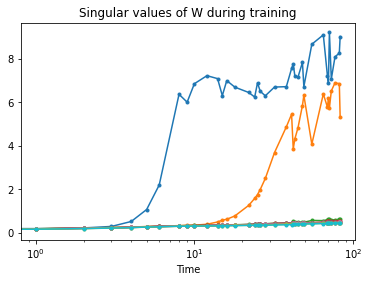

In [3]:
f, alltime = loadTMCsave(MODEL_DIR.joinpath(model_name))

nvalsing = 10 # The number of singular values to plot
S = plot_valsing_evol(f, alltime, nvalsing, scale='logx')

In [4]:
# These are all the model saved times available in the file
print(alltime)

[ 0  1  2  3  4  5  6  8  9 10 12 14 15 16 18 22 24 25 26 28 32 38 41 42
 43 45 48 49 55 65 69 70 71 73 77 82 83]


# Potential/Probability Analysis

In [5]:
# Parameters to reconstruct the probability
t = 69 # The time at which we want to compute the probability
nb_chain = 10 # nb of MC chains for each w_hat
it_mcmc = 10 # Nb of it_mcmc for each chain
it_mean = 5 # Nb of iterations to compute the mean
N = 20000 # Constraint
nb_point_dim = torch.tensor([40, 40]) # Nb of discretization points for w_hat 
border_length = 0.1
direction = torch.tensor([0, 1], device = device)


In [6]:
myRBM = loadTMCRBM2D(f, t, lr=0.1, NGibbs=10, mb_s=500, num_pcd=500, PCA=True, direction=direction, nb_point_dim=nb_point_dim, device=device, dtype=dtype)

In [7]:
square, p_m, w_hat_b = ComputeProbabilityTMC2D(myRBM, data, nb_chain, it_mcmc, it_mean, N, nb_point_dim, border_length, V, device=device)

/tmp/ipykernel_125073/2799531085.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  proba_cont = ax.contour(w_hat_b[0], w_hat_b[1], p_m.cpu().numpy(), label=r'$p(m)$') # Plot the contour of the probability


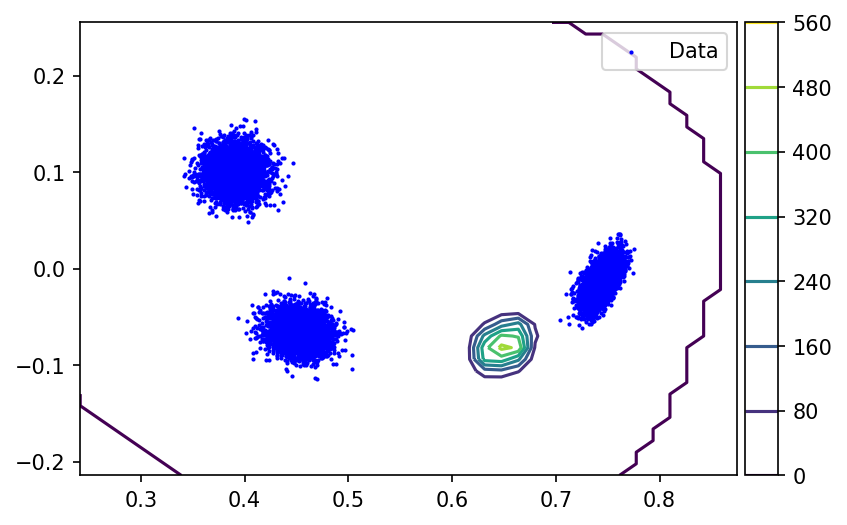

In [8]:

fig, ax = plt.subplots(dpi=150)
divider = make_axes_locatable(ax)
ax.scatter(proj_data[:, direction[0]], proj_data[:, direction[1]], c='b', s=1
           , label='Data') # Plot the data
proba_cont = ax.contour(w_hat_b[0], w_hat_b[1], p_m.cpu().numpy(), label=r'$p(m)$') # Plot the contour of the probability
ax.legend()
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(proba_cont, cax=cax, orientation='vertical')

/tmp/ipykernel_125073/3952799624.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  proba_cont = ax.contour(w_hat_b[0], w_hat_b[1], -torch.log(p_m).cpu().numpy(), label=r'$\Omega(\hat{m})$') # Plot the contour of the probability


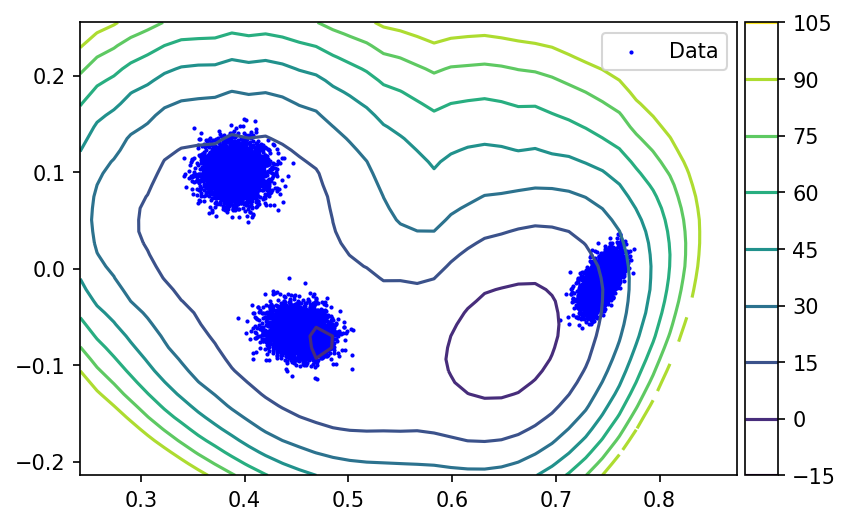

In [9]:

fig, ax = plt.subplots(dpi=150)
divider = make_axes_locatable(ax)
ax.scatter(proj_data[:, direction[0]], proj_data[:, direction[1]], c='b', s=1
           , label='Data') # Plot the data
proba_cont = ax.contour(w_hat_b[0], w_hat_b[1], -torch.log(p_m).cpu().numpy(), label=r'$\Omega(\hat{m})$') # Plot the contour of the probability
ax.legend()
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(proba_cont, cax=cax, orientation='vertical')

# Sampling


In [10]:
n_sample = 2000

In [12]:
new_sample, _ = myRBM.genDataTMC2D(n_sample, V[:,direction], it_mcmc=60)

In [13]:
proj_gen =  torch.mm(new_sample.T, V)/myRBM.Nv**.5

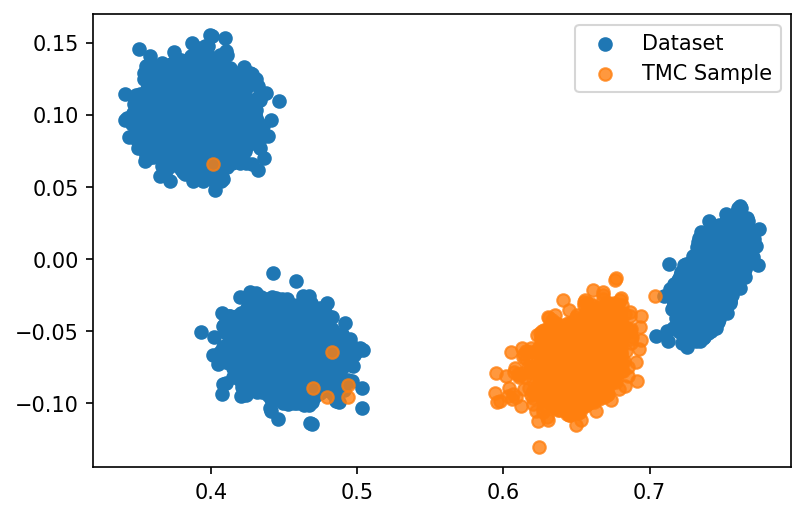

In [17]:
fig, ax = plt.subplots(1,1, dpi=150)
ax.scatter(proj_data[:,direction[0]].cpu().numpy(), proj_data[:,direction[1]].cpu().numpy(), label='Dataset')
ax.scatter(proj_gen[:,direction[0]].cpu().numpy(), proj_gen[:,direction[1]].cpu().numpy(), label='TMC Sample', alpha=.8);
ax.legend()